In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

#Load & Clean data

In [ ]:
df = pd.read_csv('adult.csv')

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
df.shape

(32561, 15)

#1. Data Inspection

• Checked data types for each column.

• Renamed columns.

•Handled invalid values.

•Treated missing and duplicated records.

•Removed unnecessary columns.

•Examined statistical summary (mean, median, std, min, max)

 Target variable distribution:
income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64


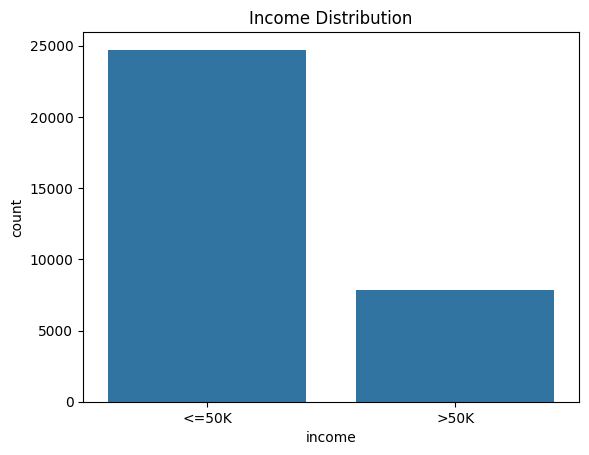

In [ ]:
print(' Target variable distribution:')
print(df['income'].value_counts(normalize=True) * 100)
sns.countplot(x='income', data=df)
plt.title('Income Distribution')
plt.show()

# Target features
Income Distribution:

•
Individuals earning <=50K account for approximately 75%of the total samples.

•
Individuals earning >50K make up only about 25%.

-> Imbalanced classes

In [ ]:
# Normalize column names
df.columns = df.columns.str.replace('.', '_').str.strip()

In [ ]:
for col in df.columns:
    count = (df[col].astype(str) == '?').sum()
    if count > 0:
        print(col)

workclass
occupation
native_country


In [ ]:
# Replace '?' with NaN and fill with mode
df.replace('?', np.nan, inplace=True)
for c in ['workclass', 'occupation', 'native.country']:
    if c in df.columns:
        df[c].fillna(df[c].mode()[0], inplace=True)

In [ ]:
# Remove duplicates and unnecessary columns
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.drop(columns=['fnlwgt'], inplace=True)

In [ ]:
for col in df.columns:
  print(f'{col} : {df[col].unique()}')

age : [90 82 66 54 41 34 38 74 68 45 52 32 51 46 57 22 37 29 61 21 33 49 23 59
 60 63 53 44 43 71 48 73 67 40 50 42 39 55 47 31 58 62 36 72 78 83 26 70
 27 35 81 65 25 28 56 69 20 30 24 64 75 19 77 80 18 17 76 79 88 84 85 86
 87]
workclass : ['Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']
education : ['HS-grad' 'Some-college' '7th-8th' '10th' 'Doctorate' 'Prof-school'
 'Bachelors' 'Masters' '11th' 'Assoc-acdm' 'Assoc-voc' '1st-4th' '5th-6th'
 '12th' '9th' 'Preschool']
education_num : [ 9 10  4  6 16 15 13 14  7 12 11  2  3  8  5  1]
marital_status : ['Widowed' 'Divorced' 'Separated' 'Never-married' 'Married-civ-spouse'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation : ['Prof-specialty' 'Exec-managerial' 'Machine-op-inspct' 'Other-service'
 'Adm-clerical' 'Craft-repair' 'Transport-moving' 'Handlers-cleaners'
 'Sales' 'Farming-fishing' 'Tech-support' 'Protective-serv' 'Armed-Forces'
 'Priv-house-serv']
relationshi

In [ ]:
# Group rare countries as "Other"
top_countries = df['native_country'].value_counts().nlargest(10).index
df['native_country'] = df['native_country'].apply(lambda x: x if x in top_countries else 'Other')

In [ ]:
df.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,32537.000000,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,10.081815,1078.443741,87.368227,40.440329
std,13.637984,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


#2. Findings:

•
Dataset contains 32,561 records and 15 columns.

•
Numerical features such as age, education_num, and hours_per_weekshow reasonable ranges without extreme outliers.

•
Mean age is 38.6, with a typical working time of about 40 hours per week.

•
Most columns are object (categorical) type, requiring encoding later in preprocessing.

#Encoding data




In [ ]:
# Encode target variable
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

In [ ]:
# Encode gender
df['sex'] = df['sex'].map({'Male': 0, 'Female': 1})

In [ ]:
# Drop text education -> numeric version exists
df.drop(columns=['education','capital_gain',	'capital_loss'], inplace=True)

In [ ]:
# Feature groups
cat_features = [i for i in df.columns if df[i].dtypes == 'object']
num_features = [i for i in df.columns if df[i].dtypes == 'int64']
print(cat_features)
print(num_features)

['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']
['age', 'education_num', 'sex', 'hours_per_week', 'income']


In [ ]:
num_cols = ['age', 'education_num', 'hours_per_week']
cat_cols = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'native_country']

# Univariate Analysis

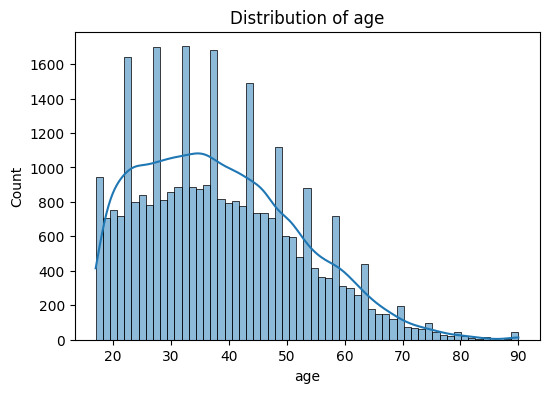

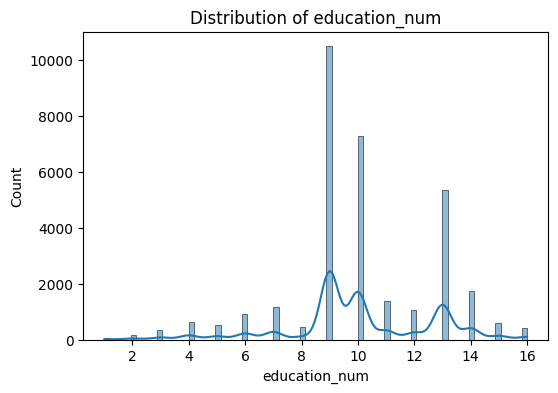

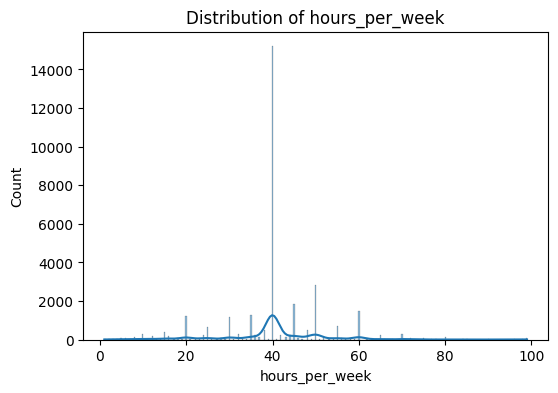

In [ ]:
# Numeric Features
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Numerical Features
AgeDistribution:

•
Right-skewed

•
Most adults are in working age.

•
Higher age -> more experience -> higher income.

EducationLevel

•
Strong peaks at 9, 10, 13

•
high school or some college education.

•
Higher education levels -> earning >50K.

HoursperWeek

•
Peaked

•
Standard workweek

•
more than 40 hours/

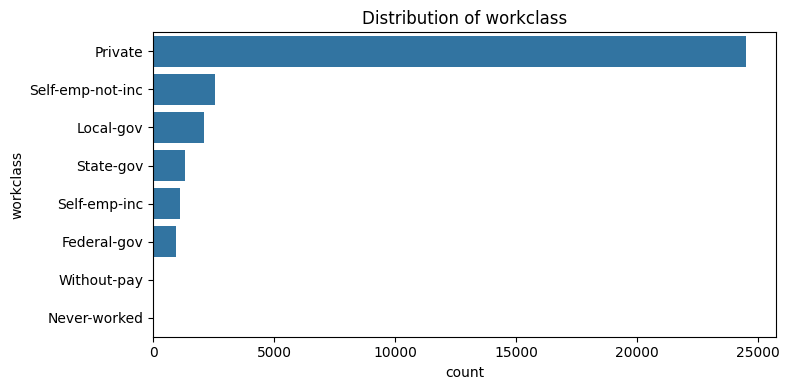

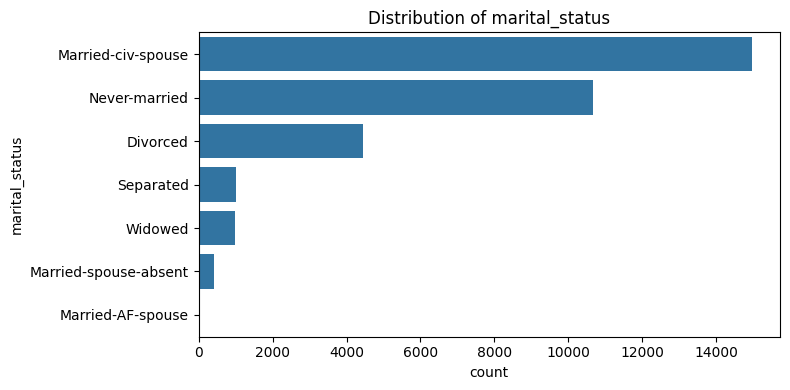

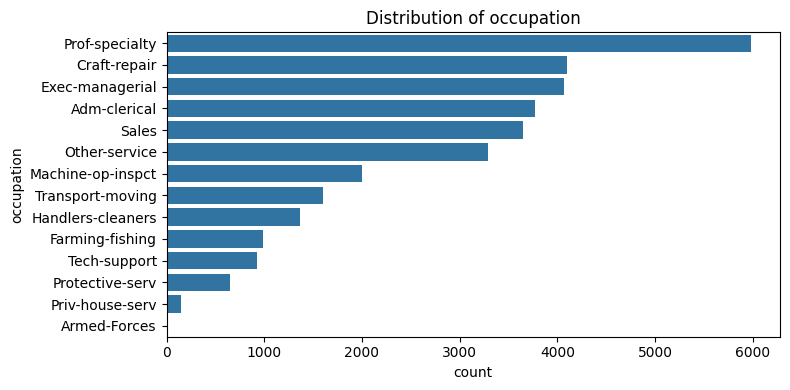

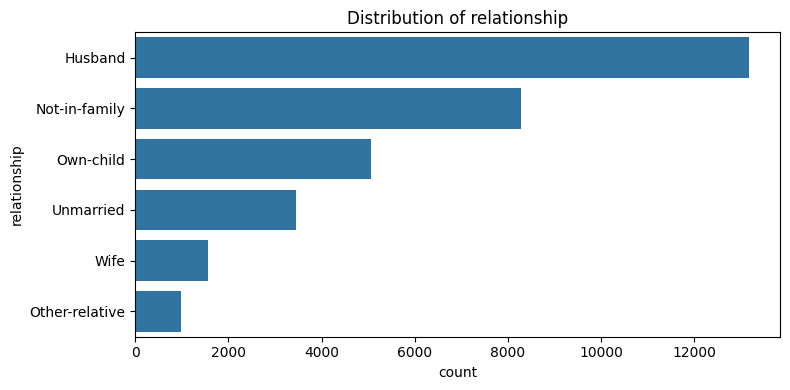

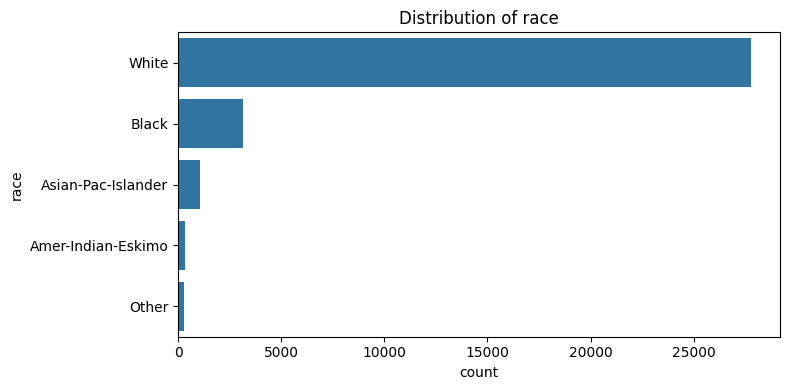

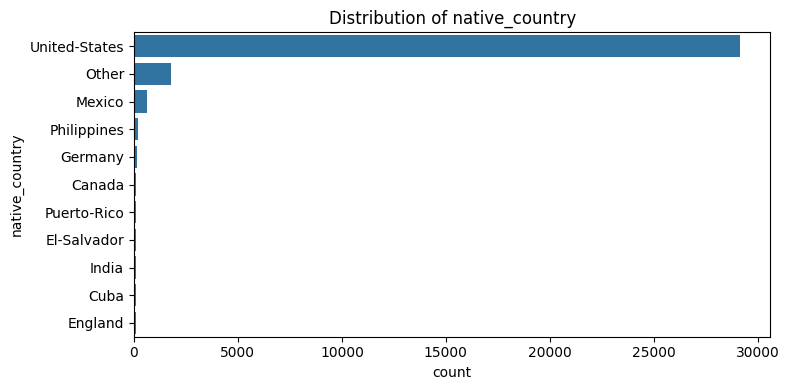

In [ ]:
# Categorical Features
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Categorical Features
•
Workclass: Most individuals work in the Private sector

•
Occupation: The most common occupations are Prof-specialty.

•
NativeCountry: Almost all participants are from the United States.

•
Race: The majority are White

•
Relationship: Husband is the most frequent category

•
MaritalStatus: Married-civ-spouse is the dominant group


# Bivariate Analysis

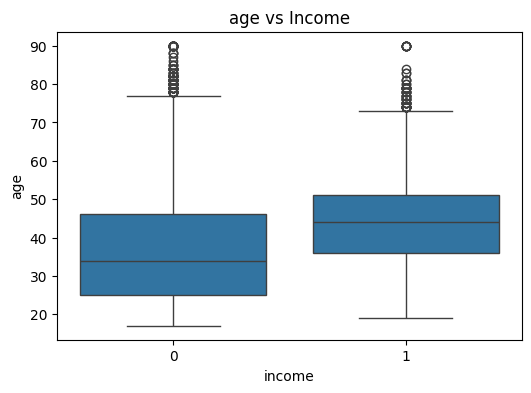

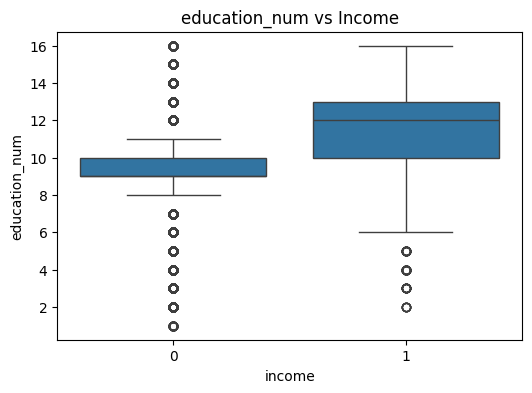

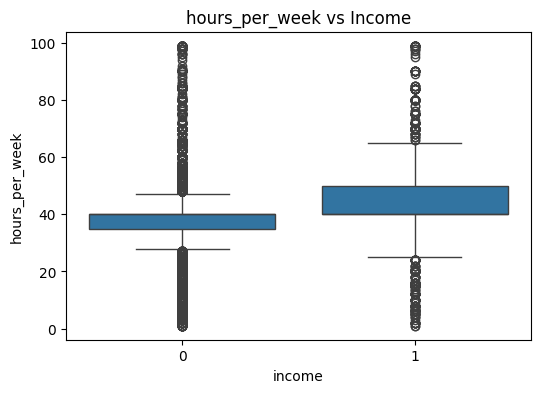

In [ ]:
# Numeric vs Target
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='income', y=col, data=df)
    plt.title(f'{col} vs Income')
    plt.show()

# Numerical Feature

**Age vs Income**

•
earning `>50K` tend to be older.

•
`>50K` group has high median age

•
outliers in both groups

•
Work experience and seniority –> high income

**Education Level vs Income**

•
more years of schooling earn >50K.

•
lower-income group is rough high school.

•
Education strongly influences income

**Hours per Week vs Income**

•
Work more hours per week -> earning >50K

•
Median for >50K group is higher than for <=50K group.

•
Outliers in both

<=50K': 0, '>50K': 1

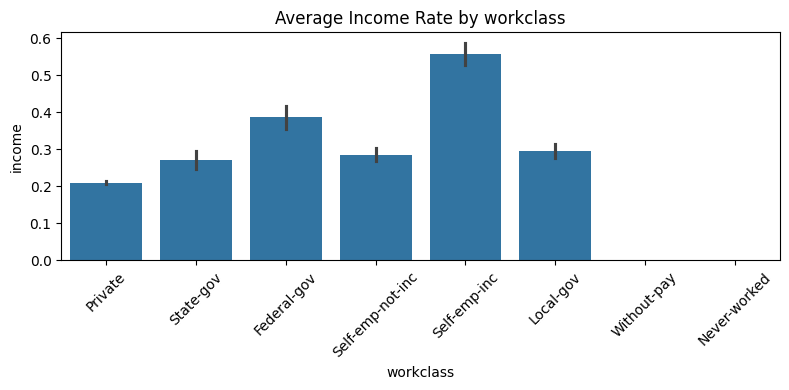

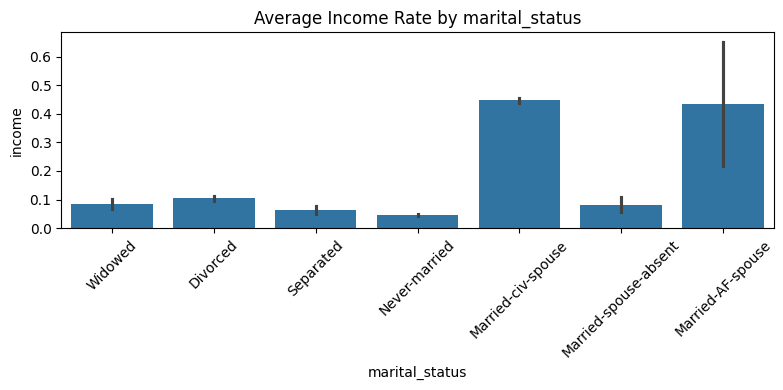

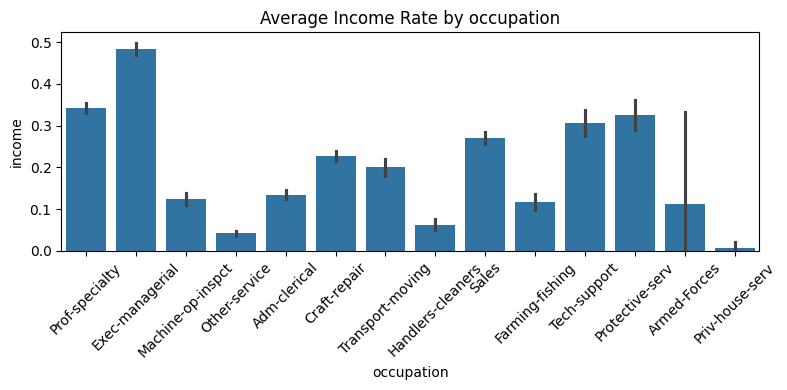

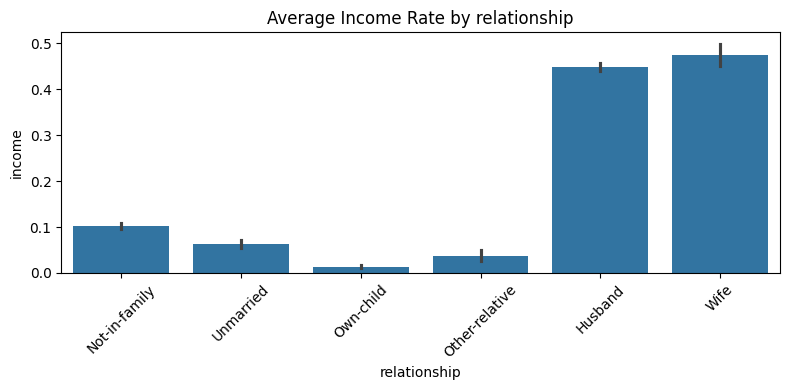

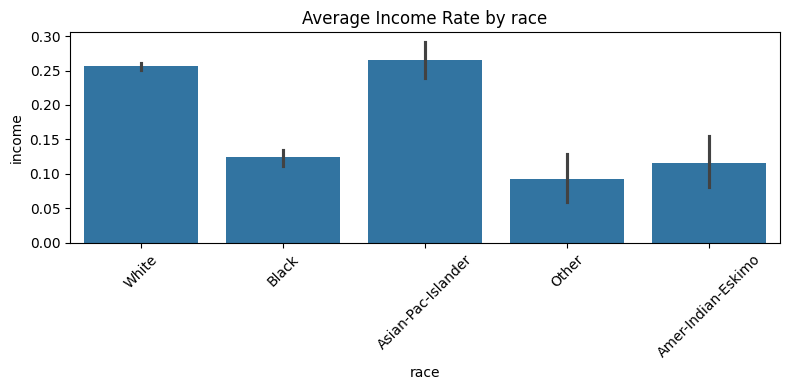

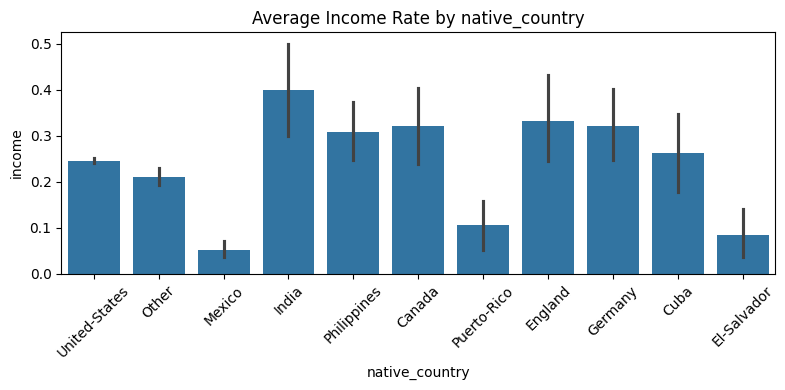

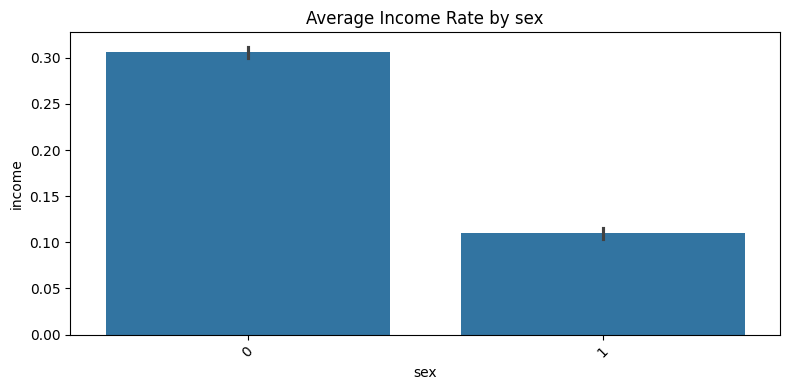

In [ ]:
# Categorical vs Target
for col in cat_cols + ['sex']:
    plt.figure(figsize=(8,4))
    sns.barplot(x=col, y='income', data=df, estimator=np.mean)
    plt.title(f'Average Income Rate by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#Categorical features

**Average Income Rate by Sex**

•
Males have a significantly higher average income rate than females.

**Average Income Rate by Relationship**

•
Husband and Wife categories have much higher income rates

**Average Income Rate by Race**

•
The Asian-Pac-Islander and White groups show higher average income rates.

**Average Income Rate by Marital Status**

•
Individuals who are Married-civ-spouse have the highest income rate

**Average Income Rate by Workclass**

•
Self-emp-inc(self-employed incorporated) shows the highest income rate among all work classes.

**Average Income Rate by Occupation**

•
The Prof-specialty and Exec-managerial occupations have the highest proportion of high-income individuals.

**Average Income Rate by Native Country**

•
The majority of individuals from the United States have a moderate average income rate.

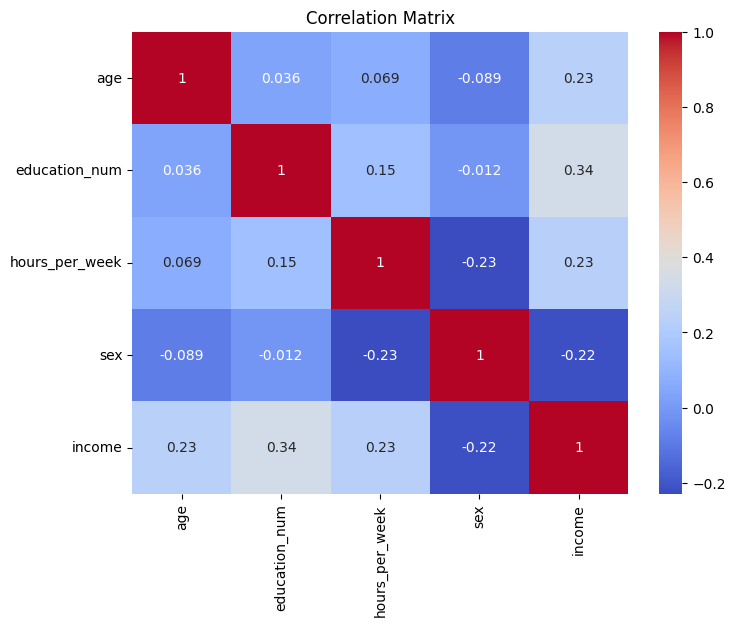

In [ ]:
# Correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + ['sex', 'income']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Correlation Analysis**

●
Education level has the strongest positive correlation with income.

●
Age and hours per week also show moderate positive correlations with income.

●
Sex has a weak negative correlation


In [ ]:
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

#Train/Test Split

Training:

●
Split into an 80:20 ratio.

●
Train all baseline models (before hyperparameter tuning).

●
Tune the hyperparameters of each model.

●
Compare the results

In [ ]:
X = df.drop(columns='income')
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Scale numeric features
scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
# handle class imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('Class distribution after SMOTE:')
print(y_train_res.value_counts())

Class distribution after SMOTE:
income
0    19758
1    19758
Name: count, dtype: int64


Models:

●
Logistic Regression

●
Decision Tree

●
Random Forest

●
Gradient Boosting

In [ ]:
# train base models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

print('Base Model Evaluation:')
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f'{name}')
    print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
    print(f'AUC: {roc_auc_score(y_test, y_proba):.4f}')

Base Model Evaluation:
Logistic Regression
              precision    recall  f1-score   support

       <=50K       0.93      0.77      0.84      4940
        >50K       0.53      0.82      0.65      1568

    accuracy                           0.78      6508
   macro avg       0.73      0.80      0.75      6508
weighted avg       0.84      0.78      0.80      6508

Accuracy: 0.7838
F1-score: 0.6471
AUC: 0.8814
Decision Tree
              precision    recall  f1-score   support

       <=50K       0.86      0.85      0.85      4940
        >50K       0.54      0.55      0.54      1568

    accuracy                           0.78      6508
   macro avg       0.70      0.70      0.70      6508
weighted avg       0.78      0.78      0.78      6508

Accuracy: 0.7775
F1-score: 0.5424
AUC: 0.7218
Random Forest
              precision    recall  f1-score   support

       <=50K       0.88      0.86      0.87      4940
        >50K       0.58      0.62      0.60      1568

    accuracy       

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
for name, model in models.items():
  model.fit(X_train_res, y_train_res)
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  print(f'Confusion Matrix - {name}' , cm)

Confusion Matrix - Logistic Regression [[3811 1129]
 [ 278 1290]]
Confusion Matrix - Decision Tree [[4202  738]
 [ 710  858]]
Confusion Matrix - Random Forest [[4235  705]
 [ 603  965]]
Confusion Matrix - Gradient Boosting [[3958  982]
 [ 317 1251]]


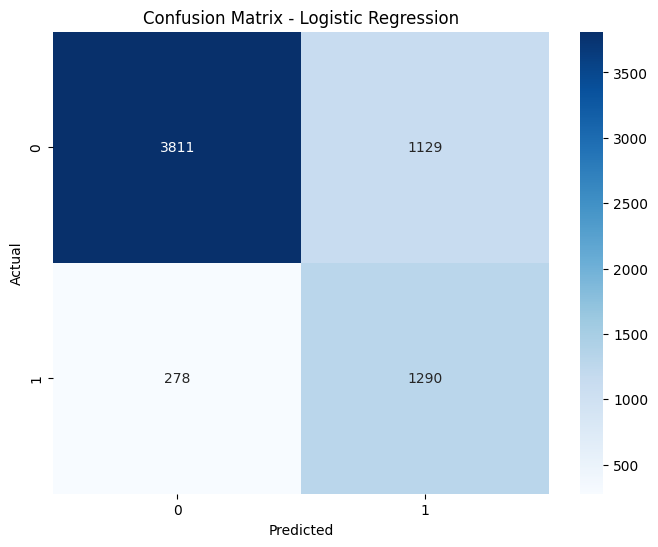

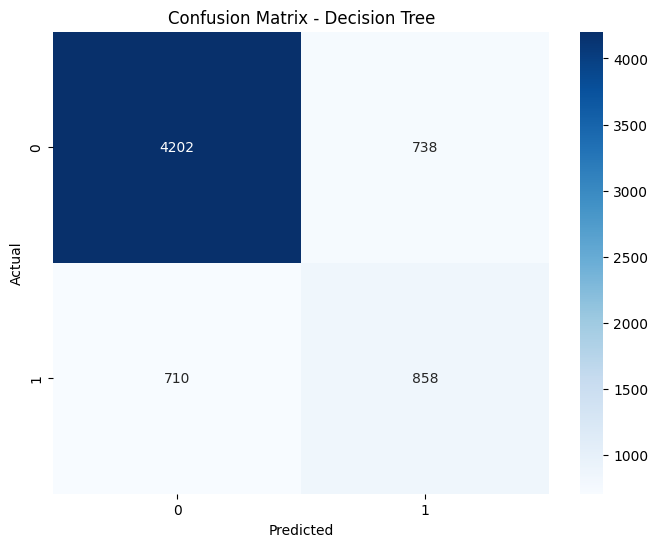

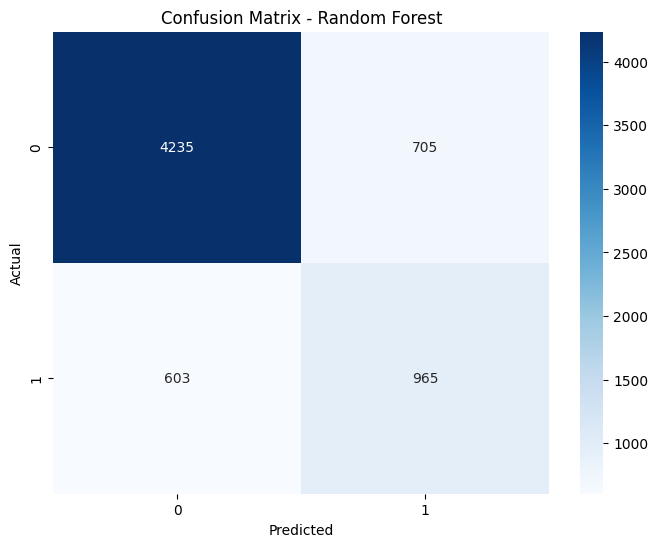

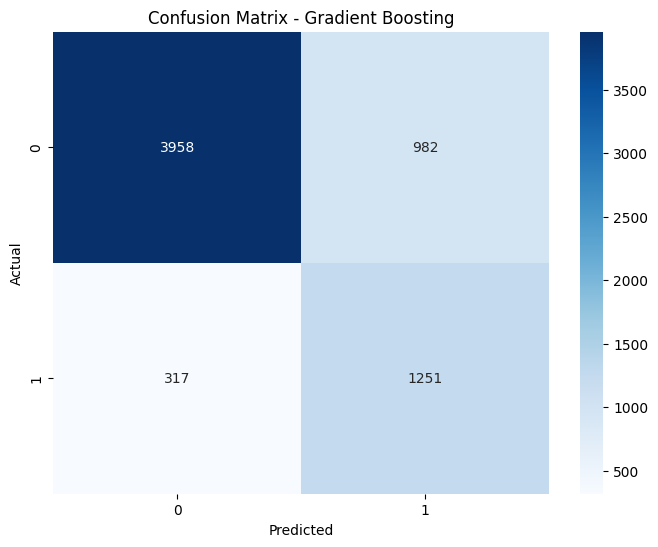

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
for name, model in models.items():
  model.fit(X_train_res, y_train_res)
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix - {name}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

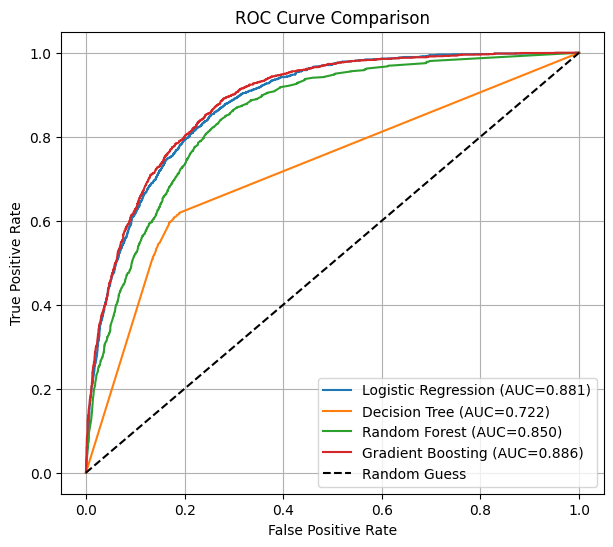

In [ ]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
summary = []
plt.figure(figsize=(7,6))
# Plot all ROC curves
for name, model in models.items():
  model.fit(X_train_res, y_train_res)
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_proba)
  auc = roc_auc_score(y_test, y_proba)
  f1 = f1_score(y_test, y_pred)
  summary.append([name, f1, auc])
  plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Results
**Logistic Regression:**

•
High precision for <=50K, quite high accuracy.

•
F1 (>50K) 0.65 -> poor in detecting high-income individuals.

**Decision Tree:**

•
Balanced results in both class

•
Accuracy 0.78, risk of overfitting.

**Random Forest:**

•
High accuracy (0.8), low precision for >50K.

**Gradient Boosting:**

•
Best F1 overall, balanced between precision –recall.

**To sum up:**
•
All models have similar accuracy score (0.78-0.8)

•
Gradient Boosting provide the best balance precision, recall, F1 score.

•
Logistic Regression performs well for <=50K, but poorly for >50K.

•
Decision Tree,Random Forest perform moderately.

** ROC- AUC Score**

•
Logistic Regression and Gradient Boosting achieved the highest AUC scores.
➔
Strong discriminative ability between income classes.
•
Decision Tree performs the weakest (overfitting).

# Hyperparameter Tuning

In [ ]:
# Logistic Regression
param_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                       param_grid=param_lr, scoring='f1', cv=3, n_jobs=-1)
grid_lr.fit(X_train_res, y_train_res)
best_lr = grid_lr.best_estimator_
print('Logistic Regression best params:', grid_lr.best_params_)

Logistic Regression best params: {'C': 10, 'solver': 'liblinear'}


In [ ]:
# Decision Tree
param_dt = {'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=param_dt, scoring='f1', cv=3, n_jobs=-1)
grid_dt.fit(X_train_res, y_train_res)
best_dt = grid_dt.best_estimator_
print('Decision Tree best params:', grid_dt.best_params_)

Decision Tree best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [ ]:
# Random Forest
param_rf = {'n_estimators': [100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=param_rf, scoring='f1', cv=3, n_jobs=-1)
grid_rf.fit(X_train_res, y_train_res)
best_rf = grid_rf.best_estimator_
print('Random Forest best params:', grid_rf.best_params_)

Random Forest best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# Gradient Boosting
param_gb = {'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]}
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42),
                       param_grid=param_gb, scoring='f1', cv=3, n_jobs=-1)
grid_gb.fit(X_train_res, y_train_res)
best_gb = grid_gb.best_estimator_
print('Gradient Boosting best params:', grid_gb.best_params_)

Gradient Boosting best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


# Evaluation After Tuning

In [ ]:
# train base models
models_tuned = {
    'Logistic Regression (Tuned)': best_lr,
    'Decision Tree (Tuned)': best_dt,
    'Random Forest (Tuned)': best_rf,
    'Gradient Boosting (Tuned)': best_gb
}
for name, model in models_tuned.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f'{name}')
    print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'F1-score: {f1_score(y_test, y_pred):.4f}')
    print(f'AUC: {roc_auc_score(y_test, y_proba):.4f}')

Logistic Regression (Tuned)
              precision    recall  f1-score   support

       <=50K       0.93      0.77      0.85      4940
        >50K       0.54      0.82      0.65      1568

    accuracy                           0.79      6508
   macro avg       0.73      0.80      0.75      6508
weighted avg       0.84      0.79      0.80      6508

Accuracy: 0.7852
F1-score: 0.6487
AUC: 0.8812
Decision Tree (Tuned)
              precision    recall  f1-score   support

       <=50K       0.92      0.78      0.85      4940
        >50K       0.53      0.79      0.64      1568

    accuracy                           0.78      6508
   macro avg       0.73      0.79      0.74      6508
weighted avg       0.83      0.78      0.80      6508

Accuracy: 0.7830
F1-score: 0.6370
AUC: 0.8579
Random Forest (Tuned)
              precision    recall  f1-score   support

       <=50K       0.89      0.86      0.87      4940
        >50K       0.59      0.65      0.62      1568

    accuracy      

In [ ]:
# Confusion Matrix
models_tuned = {
    'Logistic Regression (Tuned)': best_lr,
    'Decision Tree (Tuned)': best_dt,
    'Random Forest (Tuned)': best_rf,
    'Gradient Boosting (Tuned)': best_gb
}

for name, model in models_tuned.items():
  model.fit(X_train_res, y_train_res)
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  print(f'Confusion Matrix - {name}', cm)


Confusion Matrix - Logistic Regression (Tuned) [[3819 1121]
 [ 277 1291]]
Confusion Matrix - Decision Tree (Tuned) [[3857 1083]
 [ 329 1239]]
Confusion Matrix - Random Forest (Tuned) [[4247  693]
 [ 550 1018]]
Confusion Matrix - Gradient Boosting (Tuned) [[3996  944]
 [ 322 1246]]


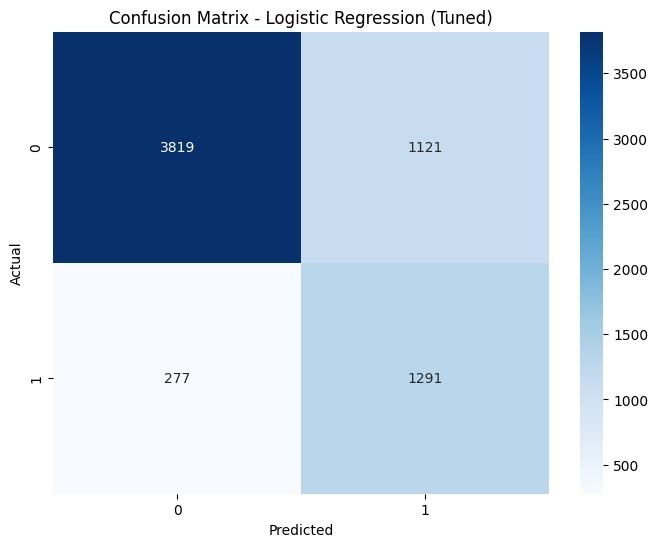

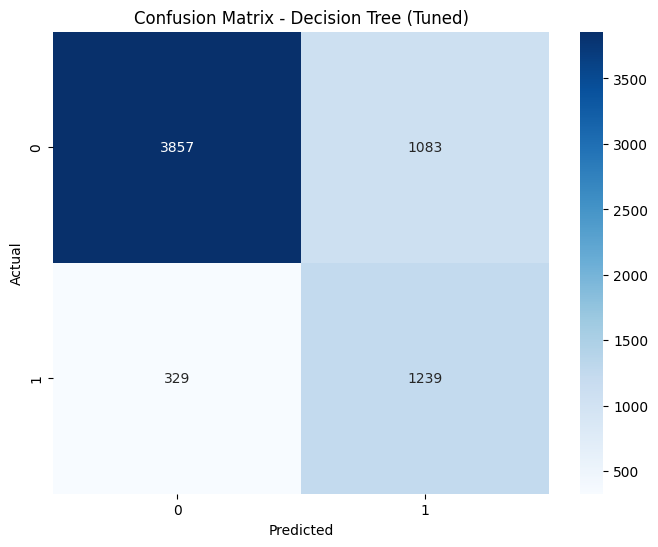

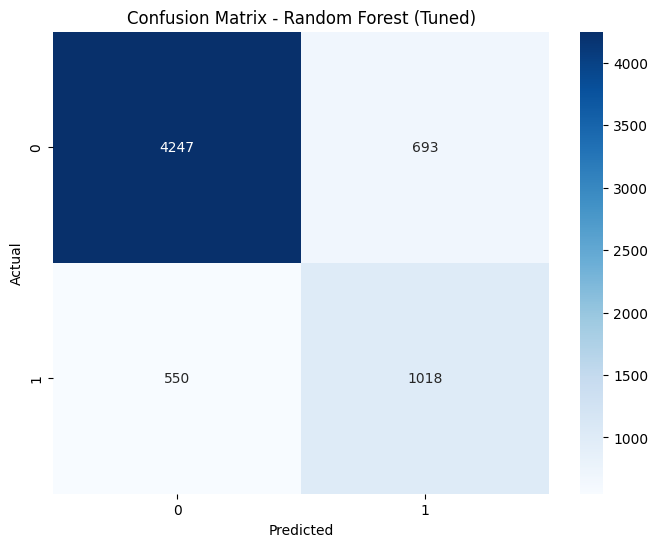

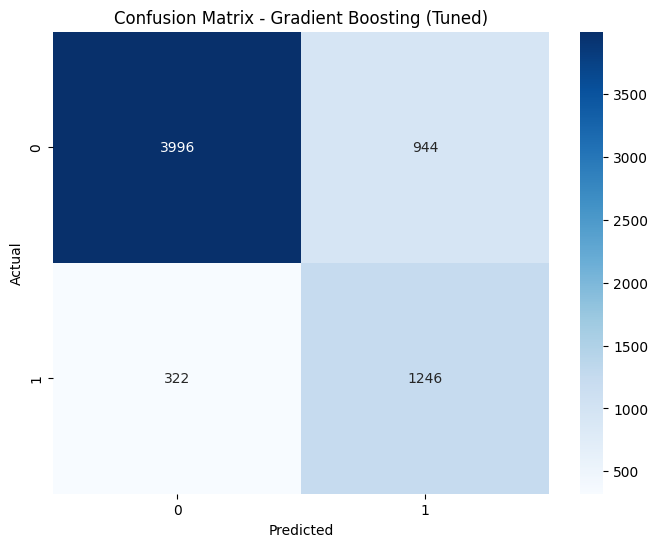

In [ ]:
# Confusion Matrix
models_tuned = {
    'Logistic Regression (Tuned)': best_lr,
    'Decision Tree (Tuned)': best_dt,
    'Random Forest (Tuned)': best_rf,
    'Gradient Boosting (Tuned)': best_gb
}

for name, model in models_tuned.items():
  model.fit(X_train_res, y_train_res)
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix - {name}')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()


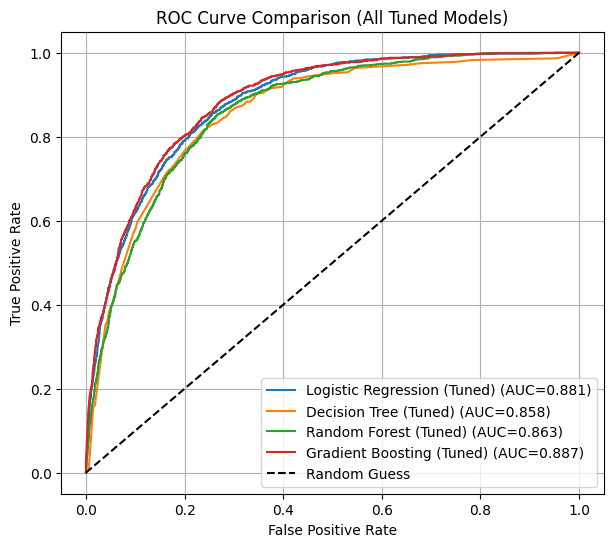

In [ ]:
models_tuned = {
    'Logistic Regression (Tuned)': best_lr,
    'Decision Tree (Tuned)': best_dt,
    'Random Forest (Tuned)': best_rf,
    'Gradient Boosting (Tuned)': best_gb
}

summary = []
plt.figure(figsize=(7,6))
# Plot all ROC curves
for name, model in models_tuned.items():
  model.fit(X_train_res, y_train_res)
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_proba)
  auc = roc_auc_score(y_test, y_proba)
  f1 = f1_score(y_test, y_pred)
  summary.append([name, f1, auc])
  plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve Comparison (All Tuned Models)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

**Logistic regression:**

•
Accuracy score improved slightly.

•
Limitation improvement, F1 for > 50K still 0.65.

**Decision Tree:**

•
Recall for >50K increased, accuracy score 0.78.

•
F1 score is only 0.74.

**Random Forest:**

•
High accuracy score (0.81), F1 score improved.

•
Precision (>50K) is quite low.

**Gradient Boosting:**

•
Best F1 and accuracy score, good

**To sum up:**

•
All models improved slightly after hyperparameter tuning.

•
Random Forest and Gradient Boosting reached the highest accuracy (0.81).

•
Gradient Boosting remained the top model overall.

•
Decision Tree and Logistic Regression showed moderate gains but remain weaker than others

After Tunning Hyperparameter
•
Decision Tree showed the most significant improvement (0.722 –0.858)
•
Gradient Boosting achieved the highest overall performance.
➔
Tuning helps enhance models.
➔
Gradient Boosting was therefore selected as the final model (high AUC and balance

In [ ]:
# Summary table
df_summary = pd.DataFrame(summary, columns=['Model', 'F1-score', 'ROC-AUC']).sort_values('ROC-AUC', ascending=False)
print('Model Comparison After Hyperparameter Tuning:')
print(df_summary)

Model Comparison After Hyperparameter Tuning:
                         Model  F1-score   ROC-AUC
3    Gradient Boosting (Tuned)  0.663119  0.886816
0  Logistic Regression (Tuned)  0.648744  0.881191
2        Random Forest (Tuned)  0.620921  0.862526
1        Decision Tree (Tuned)  0.637018  0.857894


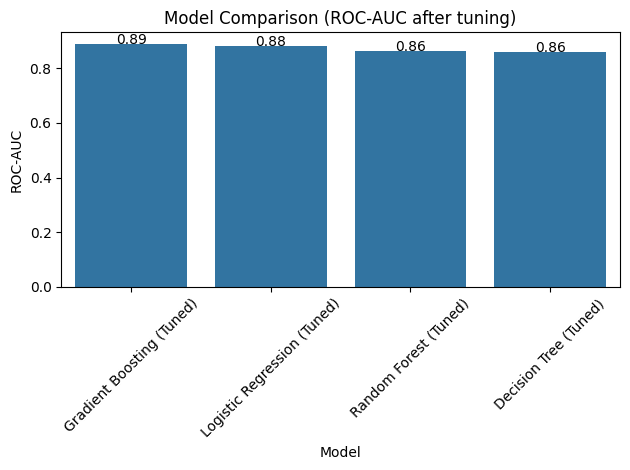

In [ ]:
# ROC-AUC bar chart
ax = sns.barplot(x='Model', y='ROC-AUC', data=df_summary)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center')
plt.xticks(rotation=45)
plt.title('Model Comparison (ROC-AUC after tuning)')
plt.tight_layout()
plt.show()

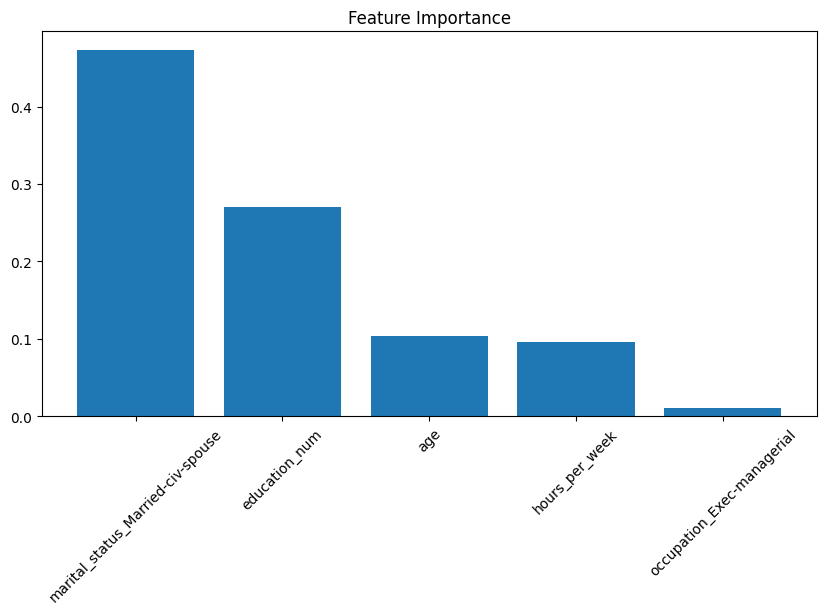

In [ ]:
# feature importance
feature_importance = pd.Series(best_gb.feature_importances_, index = X_train_res.columns)
feature_importance = feature_importance.sort_values(ascending = False).head(5)
plt.figure(figsize = (10,5))
plt.bar(x=feature_importance.index, height = feature_importance.values)
plt.title('Feature Importance')
plt.xticks(rotation =45)
plt.show()

# Conclusion

**Model Evaluation Summary:**

➢
The models perform better when using all available features.

➢
Hyperparameter tuning improves the performance of all models.

➢
**Gradient Boosting achieved the best overall result with:**

•
Highest Accuracy score: 0.81

•
Balanced precision, recall, F1 score

•
Highest ROC-AUC score: 0.887

**To sum up:**

Gradient Boosting demonstrates the strongest discriminative ability.

**Identification of Individuals by Income Group:**

**<= 50K Group(lower income):**

•
Majority of individuals in the dataset (75%).

•
Typicallyyounger and with years of education (high school or some college).

•
Often work standard or fewer hours per week (<40 hours).

•
Commonly Private employees in services or manual jobs (sales, craft,…).

•
More likely to be female, never-married or not in family relationship categories.

**`>50K` Group(higher income):**

•
Minority of the population (25%).

•
Usually older, indicating more work experience.

•
High education levels (Bachelor’s degree and above).

•
Work longer hours per week (>40 hours)

•
Frequently in professional or managerial occupation (Prof-specialty, Exec-managerial)

•
Commonly married and self-employed or in higher work position.

•
Higher percentage found among White and Asian-Pac-Islander races.